In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from tabulate import tabulate
from scipy import stats

from flaml import AutoML
from flaml.automl.data import get_output_from_log

from dython.nominal import associations
from mrmr import mrmr_regression, mrmr_classif

from scipy.stats import gaussian_kde

import statsmodels.api as sm

import seaborn as sns


sklearn.set_config(transform_output="pandas")

In [2]:
visits = pd.read_csv('Modified_Data/visits.csv')

## Preparing the data

In [3]:
id_columns = [col for col in visits.columns if '_id' in col]
print("We are dropping the following columns:", id_columns)
visits.drop(columns=id_columns, inplace=True)

We are dropping the following columns: ['visit_id', 'customer_id', 'transaction_id']


In [4]:
# drop columns 
visits.drop(columns=['start_timestamp', 'end_timestamp', 'user_first_name', 
                     'user_last_name', 'email', 'purchase_date', 'purchase_price', 
                     'release_date', 'month_year','switch_type'], inplace=True)

### Null values

In [5]:
visits.isna().sum()

visit_type                  0
visit_duration_time         0
gender                      0
email_domain             3787
platform               125546
user_review            398264
car_model              125546
fuel_type              125546
price                  125546
discount               125546
car_age_days           125546
purchased                   0
average_visit_time          0
visit_number                0
reviewed                    0
engaged                     0
loyalty                     0
dtype: int64

For now we don't care about those who didn't bought at least a car, so we are going to drop the nans

In [6]:
# drop the column user_review
visits.drop(columns=['user_review', 'visit_type'], inplace=True)

In [7]:
# drop the nans
visits.dropna(inplace=True)

In [8]:
y = visits['purchased']
X = visits.drop(columns=['purchased'])

In [9]:
# get dummies
X = pd.get_dummies(X)
X.shape

(312983, 34)

## Analyse the features

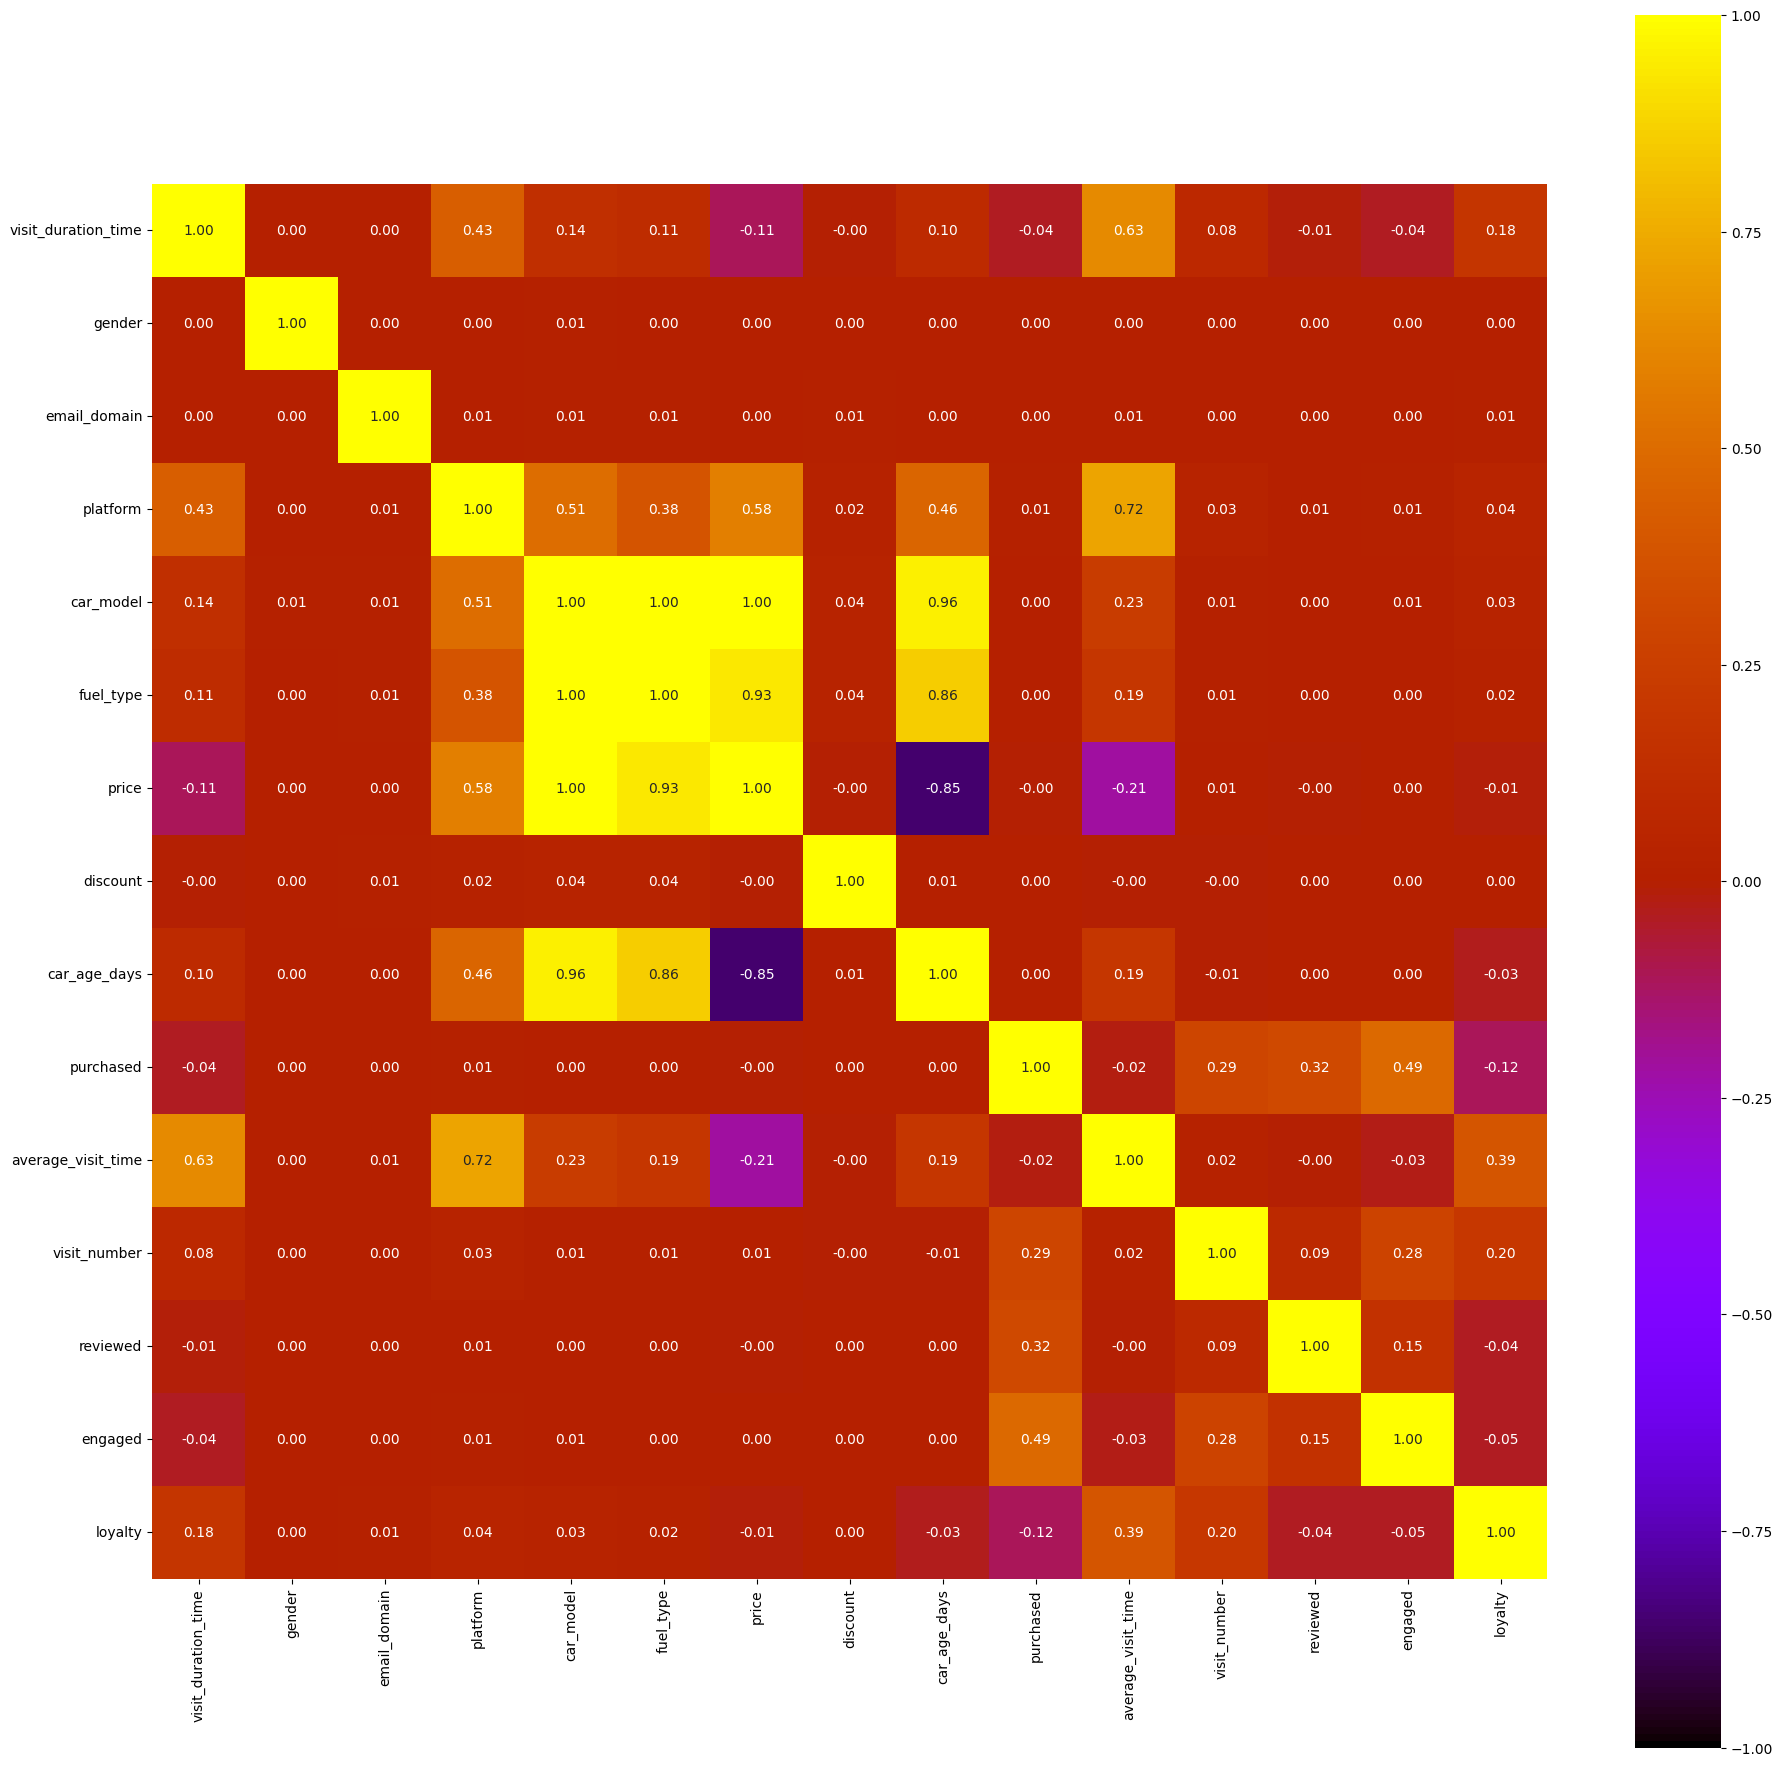

In [10]:
associations = associations(visits, multiprocessing=True, cmap='gnuplot', num_num_assoc='spearman')

In [11]:
selected_features = mrmr_classif(X=X, y=y, K=100)
print(selected_features)

100%|██████████| 34/34 [00:13<00:00,  2.54it/s]

['engaged', 'reviewed', 'visit_number', 'visit_duration_time', 'loyalty', 'platform_Mobile App', 'average_visit_time', 'email_domain_gmail.com', 'platform_Dealership', 'gender_Other', 'car_model_Sedan', 'car_model_1 Series', 'discount', 'car_age_days', 'fuel_type_Diesel', 'email_domain_hotmail.com', 'gender_Male', 'fuel_type_Gasoline', 'price', 'car_model_Model M', 'car_model_Model i7', 'car_model_Model iX', 'car_model_Sierra', 'platform_Website', 'fuel_type_Electric', 'car_model_3 Series', 'car_model_Model i8', 'gender_Female', 'car_model_Touring', 'car_model_Model iY', 'email_domain_outlook.com', 'email_domain_yahoo.com', 'car_model_Coupe', 'car_model_Tourer']


## Train

In [12]:
# creating the train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [36]:
automl = AutoML()
automl.fit(X_train, y_train, task="classification", time_budget=3600 , metric="f1", log_file_name="purchased.log", n_jobs=-1, verbose=3)

[flaml.automl.logger: 12-03 10:11:35] {1728} INFO - task = classification
[flaml.automl.logger: 12-03 10:11:35] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-03 10:11:36] {1838} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 12-03 10:11:36] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 12-03 10:11:36] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-03 10:11:36] {2393} INFO - Estimated sufficient time budget=62703s. Estimated necessary time budget=1452s.
[flaml.automl.logger: 12-03 10:11:36] {2442} INFO -  at 4.4s,	estimator lgbm's best error=1.0000,	best estimator lgbm's best error=1.0000
[flaml.automl.logger: 12-03 10:11:36] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-03 10:11:36] {2442} INFO -  at 4.6s,	estimator lgbm's best error=1.0000,	best estimator lgbm's best error=1.0000
[flaml.automl.logger: 12-

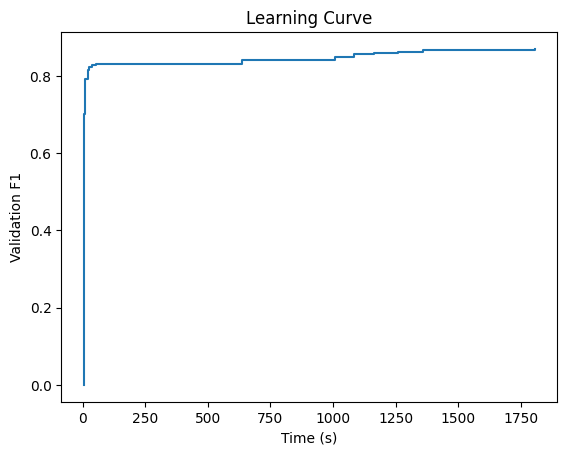

Best Configuration based on the best validation loss:
lgbm
{'n_estimators': 143, 'num_leaves': 588, 'min_child_samples': 4, 'learning_rate': 0.19001318344547957, 'log_max_bin': 10, 'colsample_bytree': 0.5411508919087042, 'reg_alpha': 0.029139600936312147, 'reg_lambda': 0.05662388017689599, 'FLAML_sample_size': 225347}


In [13]:
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = get_output_from_log(filename="purchased.log", time_budget=7200)

plt.title("Learning Curve")
plt.xlabel("Time (s)")
plt.ylabel("Validation F1")
plt.step(time_history, 1 - np.array(best_valid_loss_history), where="post")
plt.show()


# Find the index of the best validation loss
best_index = np.argmin(best_valid_loss_history)

# Get the best configuration from the config history
best_config = config_history[best_index]

learner_name = best_config["Current Learner"]
hyperparameters = best_config["Current Hyper-parameters"]

# print the best configuration as a dictionary
print("Best Configuration based on the best validation loss:")
print(best_config["Current Learner"])
print(best_config["Current Hyper-parameters"])

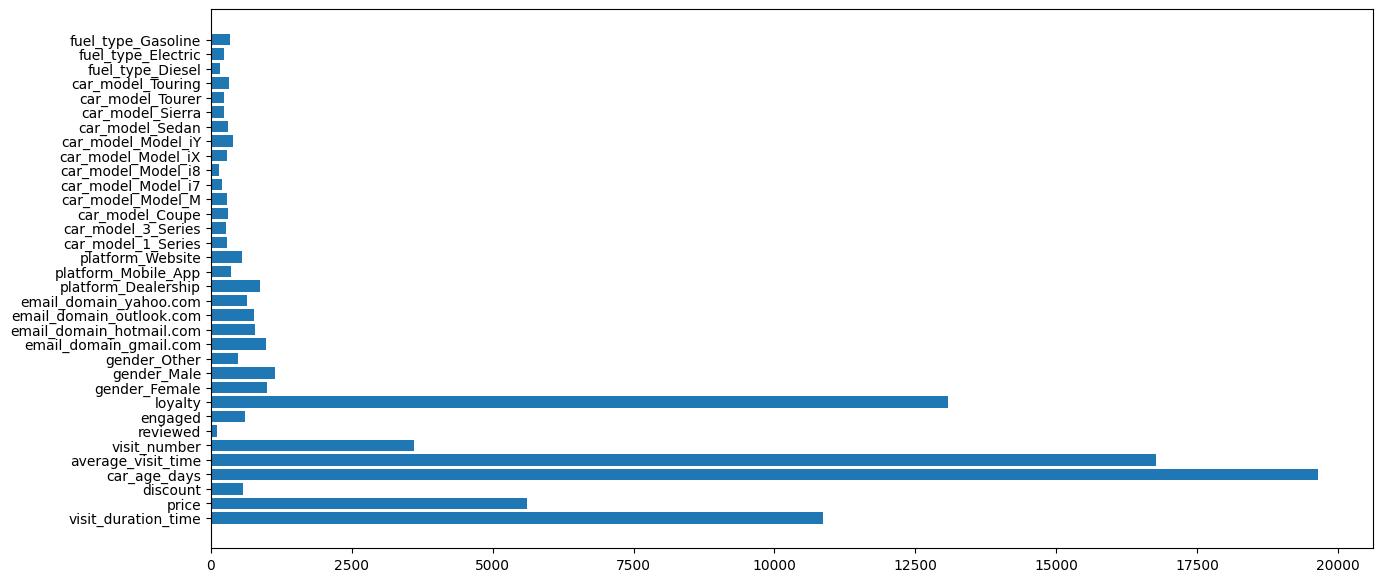

In [ ]:
try:
    plt.figure(figsize=(15, 7))
    plt.barh(automl.model.estimator.feature_name_, automl.model.estimator.feature_importances_)
except Exception as e:
    print(e)
    pass

In [39]:
# get the most useful features
print(tabulate(sorted(zip(automl.model.estimator.feature_importances_, X.columns), reverse=True)))

-----  ------------------------
20505  car_age_days
19325  average_visit_time
13142  loyalty
10164  visit_duration_time
 4889  price
 3655  visit_number
  779  platform_Dealership
  687  gender_Male
  675  gender_Female
  619  engaged
  611  email_domain_gmail.com
  608  email_domain_hotmail.com
  597  email_domain_outlook.com
  559  email_domain_yahoo.com
  515  discount
  478  platform_Website
  405  gender_Other
  343  car_model_Model iY
  303  platform_Mobile App
  282  fuel_type_Gasoline
  279  car_model_Coupe
  274  car_model_Sedan
  252  car_model_Touring
  234  car_model_Model iX
  231  car_model_Tourer
  226  fuel_type_Electric
  221  car_model_Model M
  220  car_model_Model i7
  214  car_model_1 Series
  207  car_model_3 Series
  173  car_model_Sierra
  148  car_model_Model i8
  145  fuel_type_Diesel
  113  reviewed
-----  ------------------------


The analysis suggests that we can easily predict if a user is going to buy a car or not. The most important features influencing the prediction are:

1. Car Age (in days)
2. Average Visit Time
3. Loyalty
4. Visit Duration Time
5. Price
6. Visit Number
7. platform_Dealership

From the feature importance analysis, it is evident that user behavior metrics such as average visit time, visit duration, and visit number play a significant role in predicting car purchases. Additionally, factors like car age, loyalty, price, and engagement also contribute to the prediction model. This insight can help in targeting potential buyers more effectively and improving marketing strategies.

## Results

In [40]:
y_pred = automl.predict(X_test)

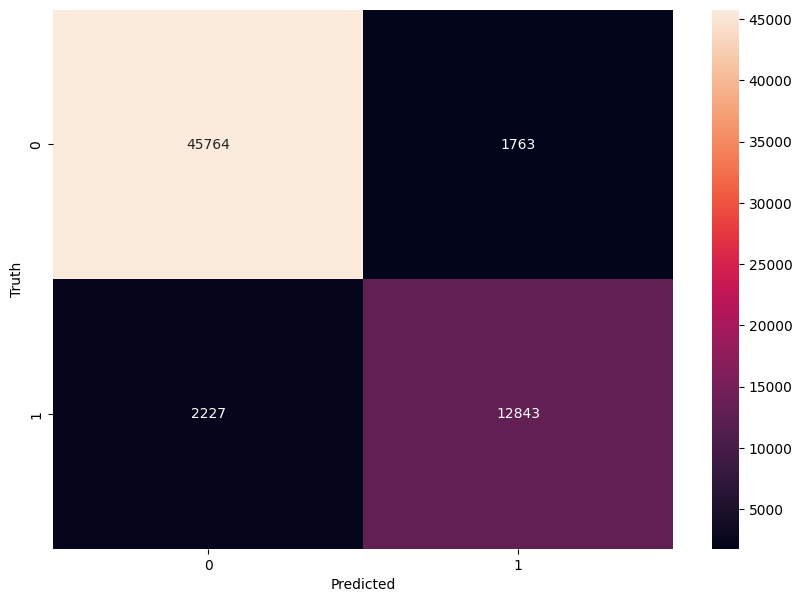

In [41]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [42]:
# metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


metrics = [
    ["Accuracy", accuracy],
    ["Precision", precision],
    ["Recall", recall],
    ["F1 Score", f1]
]

print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="grid"))

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Accuracy  | 0.936259 |
+-----------+----------+
| Precision | 0.879296 |
+-----------+----------+
| Recall    | 0.852223 |
+-----------+----------+
| F1 Score  | 0.865548 |
+-----------+----------+


Just as reminder: 

![Precision vs Accuracy](./image/Precision%20vs%20accuracy.png "Just as reminder")

The metrics indicate that it is possible to predict whether a user will purchase a car with a reasonable level of accuracy.